## Initialisation

### Dependencies

#### Third party

In [1]:
from matplotlib import pyplot as plt, ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression 
from scipy import optimize 
from IPython.display import Latex                                                                                                                                                                                                                                                                

#### Personal notebooks

In [2]:
import ipynb
from ipynb.fs.full.dataset_initialisation import (
    x,
    y,
    x_label,
    y_label,
    OUTPUT_DIR,
    ifile,
    ofile,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    group_by,
    find_nearest,
)

An index file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): n
An output file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): n


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Plot of Engineering Strain v/s Engineering Stress

### Sanitise dataset and plot $e$ v/s $s$

1. Remove the values where $s < 0$.
2. Group multiple values of $s$ corresponding to the same value of $e$.

In [3]:
# Remove negative engineering stresses
item = len(x) - 1
delete = []
while item >=0:
  if y[item] < 0:
    delete.append(item)
  item -= 1

_ = x.drop(delete)
_ = y.drop(delete)

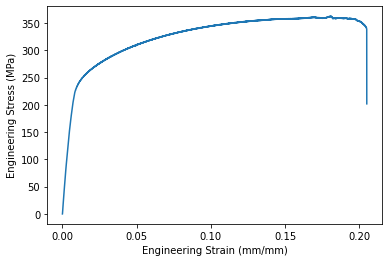

In [4]:
x, y = group_by(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
_ = plt.plot(x,y)
plt.savefig( f'{OUTPUT_DIR}/Engineering stress vs strain', facecolor='white', transparent=True)

### Reduce noise in the curve

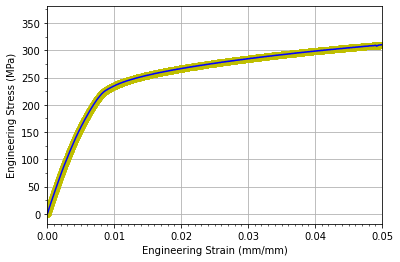

In [5]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

fig , ax = plt.subplots(1,1)
y_smooth = smooth(y,5)
ax.plot(x,y, 'yo')
ax.plot(x, y_smooth, color = 'blue')
ax.grid(True)
ax.set_xlim(0,0.05)

ax.xaxis.set_minor_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(25))
_ = plt.xlabel(x_label)
_ = plt.ylabel(y_label)

## Calculation of Young's modulus ($E$)

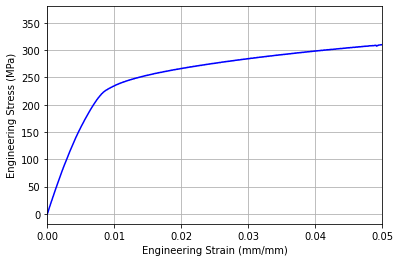

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 0.007
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 210


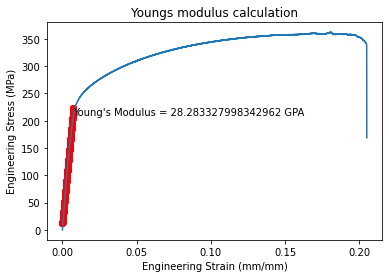

Young's Modulus: 28.283327998342962 GPa


In [11]:
fig , ax1 = plt.subplots(1,1)

ax1.plot(x, y_smooth, color = 'blue')
ax1.grid(True)
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(0,0.05)
plt.pause(0.001)

educated_guess_strain = float(input(
    'Enter the value of engineering strain upto which the line seems linear '
    '(used in calculation of Youngs modulus) in the units same as in dataset: '
    ))
educated_guess_stress = float(input(
    'Enter the value of engineering stress upto which the line seems linear '
    '(used in calculation of Youngs modulus) in the units same as in dataset: '
    ))
guessed_index = find_nearest(x, y_smooth, educated_guess_strain, educated_guess_stress)

x_smooth = sm.add_constant(x) 
result = sm.OLS(y_smooth[:guessed_index], x_smooth[:guessed_index]).fit() 

_, youngs_modulus = result.params

y_linear = [(i*youngs_modulus + _) for i in x]

fig , ax2 = plt.subplots(1,1)

ax2.plot(x[:guessed_index],y_linear[:guessed_index], 'ro')
ax2.plot(x,y_smooth)

ax2.annotate(f'Young\'s Modulus = {youngs_modulus/1000} GPA', xy=(x[guessed_index], y[guessed_index]))

ax2.set_xlabel(x_label)
ax2.set_ylabel(y_label)
ax2.set_title('Youngs modulus calculation')
plt.show()

print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')

_ = fig.savefig(f'{OUTPUT_DIR}/Youngs modulus calculation', facecolor='white', transparent=True)

if ifile.add_parameter('youngs_modulus', youngs_modulus):
    ofile.save_parameter('Young\'s Modulus', youngs_modulus, 'MPa')

## Calculation of Yield strength ($\sigma_{ys}$)

Yield Strength: 236.470693 MPa


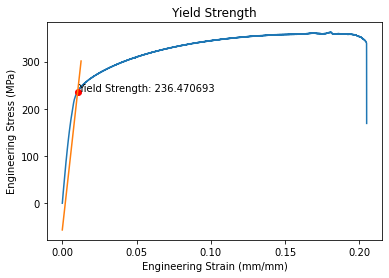

In [7]:
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x]

fig, ax = plt.subplots(1,1)
ax.plot(x,y_smooth)

intersection = np.argwhere(np.diff(np.sign([parallel_line_y[i] - y_smooth[i] for i in range(len(y_smooth))]))).flatten()
ax.plot(x[intersection[0]], y_smooth[intersection[0]], 'ro')

# 200 is added as a scaling factor so that the intersection point is easily viewable
ax.plot(x[:(intersection[0]+200)], parallel_line_y[:(intersection[0]+200)])
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Yield Strength')
yield_strength = y_smooth[intersection[0]]
ax.annotate(f'Yield Strength: {yield_strength}', (x[intersection[0]], y_smooth[intersection[0]]))

plt.savefig(f'{OUTPUT_DIR}/Yield Strength', facecolor='white', transparent=True)

# 0th index because there is only one intersection point
print(f'Yield Strength: {yield_strength} MPa')

if ifile.add_parameter('yield_strength', yield_strength):
    ofile.save_parameter('Yield Strength', yield_strength, 'MPa')

## Calculation of Ultimate tensile strength ($\sigma_{uts}$)

Ultimate Tensile Strength is 362.20079200000004 MPa at 18.095% elongation.


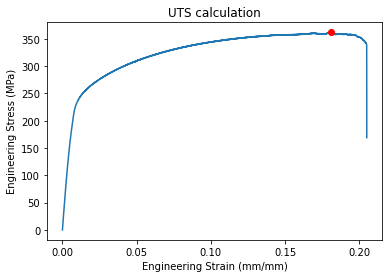

In [8]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y_smooth[uts_abscissa]
for i in range(0,len(y_smooth)):
    if y_smooth[i] >= uts:
        uts = y_smooth[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]

fig, ax = plt.subplots(1,1)
ax.plot(x,y_smooth)
ax.plot(uts_strain, uts, 'ro')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('UTS calculation')
_ = plt.savefig(f'{OUTPUT_DIR}/UTS calculation', facecolor='white', transparent=True)
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')

if ifile.add_parameter('uts', uts):
    ofile.save_parameter('Ultimate Tensile Strength', uts, 'MPa')

if ifile.add_parameter('uts_strain', uts_strain):
    ofile.save_parameter('Uniform Elongation', uts_strain, '')

### Plastic Region

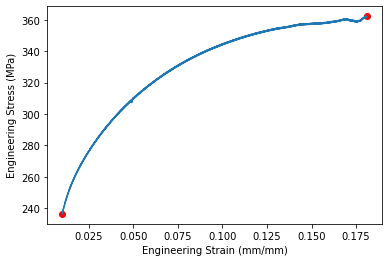

In [9]:
fig, ax = plt.subplots(1,1)

ax.plot(x[intersection[0]], y_smooth[intersection[0]], 'ro') # YS
ax.plot(uts_strain, uts, 'ro') # UTS
# there is only one intersection point
start = intersection[0]
end = uts_abscissa+1
ax.plot(x[start:end], y_smooth[start:end])
# supresses ouput while setting x,y labels
_ = ax.set_xlabel(x_label)
_ = ax.set_ylabel(y_label)

In [10]:
x_plastic_region = x[start:end]
y_smooth_plastic_region = y_smooth[start:end]

pd.DataFrame(
    np.transpose(np.asarray([x_plastic_region, y_smooth_plastic_region]))
).to_csv(f'{OUTPUT_DIR}/plastic_region.csv', index=False, header=False)